In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
z, h, herr = np.loadtxt("Hz_BC03_all.dat", unpack=True)
print(z,h,herr)

[0.09  0.17  0.179 0.199 0.27  0.352 0.4   0.48  0.593 0.68  0.781 0.875
 0.88  0.9   1.037 1.3   1.43  1.53  1.75 ] [ 69.  83.  75.  75.  77.  83.  95.  97. 104.  92. 105. 125.  90. 117.
 154. 168. 177. 140. 202.] [12.  8.  4.  5. 14. 14. 17. 62. 13.  8. 12. 17. 40. 23. 20. 17. 18. 14.
 40.]


In [3]:
def H_model(z,h_0,omega_m):
    return h_0*np.sqrt(omega_m * (1+z)**3 + 1-omega_m)

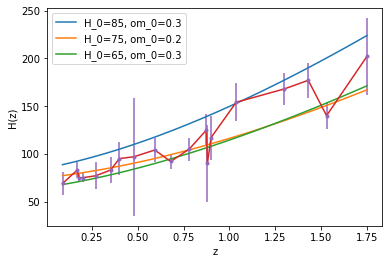

In [21]:
# 1
z_interval = np.linspace(np.min(z), np.max(z), 100)

plt.plot(z_interval,H_model(z_interval,85,0.3))
plt.plot(z_interval,H_model(z_interval,75,0.2))
plt.plot(z_interval,H_model(z_interval,65,0.3))

plt.plot(z,h)
plt.xlabel("z")
plt.ylabel("H(z)")
plt.errorbar(z,h,yerr=herr,fmt=".")
plt.legend(["H_0=85, om_0=0.3","H_0=75, om_0=0.2","H_0=65, om_0=0.3"])

In [8]:
# 2
def prior_dist(h_0,omega_m):
    #La distribució prior és una uniforme per defecte
    # on 50 < H_0 < 100 i 0 < omega_m < 1 => 1/50
    if 0 < omega_m < 1:
        prior_om = 1.0
    else:
        prior_om = 0.0
    if 50 < h_0 < 100:
        prior_h = 1.0
    else:
        prior_h = 0.0
    return prior_om * prior_h

def loglikelihood(z,h,herr,h_0,omega_m):
    #z, h, herr = data
    chisq = np.sum((h - H_model(z,h_0,omega_m))**2 / (herr**2))
    return -chisq/2

def proposal_distribution_sample(mean_list,std_list):
    # Sampling from an uncorrelated 2D normal distribution
    mean0 , mean1 = mean_list
    std0 , std1 = std_list
    return np.random.normal(mean0,std0), np.random.normal(mean1,std1)



In [16]:
# 3

def Metropolis(initial_sample,z,h,herr,std_list,iters=10**6,burn_in=10**5):
    # We assume symmetry on the proposal distribution
    props_accepted = 0
    chain = np.zeros((iters,2),dtype=float)
    chain[0] = initial_sample

    loglike = loglikelihood(z,h,herr,chain[0,0],chain[0,1])
    prior = prior_dist(chain[0,0],chain[0,1])
    post_likelihood_c = loglike + np.log(prior)

    for iter in range(1,iters):
        h0_prop, om0_prop = proposal_distribution_sample(chain[iter-1],std_list)

        loglike = loglikelihood(z,h,herr,h0_prop, om0_prop)
        prior = prior_dist(h0_prop, om0_prop)
        post_likelihood = loglike + np.log(prior)
        ratio = np.exp(post_likelihood - post_likelihood_c)

        if ratio >= np.random.uniform(0,1):
            props_accepted += 1
            chain[iter] = h0_prop, om0_prop
            post_likelihood_c = post_likelihood
        else:
            chain[iter] = chain[iter-1]

    return chain[burn_in:], props_accepted/iters



In [17]:
initial_params = [[85,0.3],[55,0.5],[70,0.9],[90,0.7]]
std_list = [1,0.1]
results = []
for param in tqdm(initial_params):
    results.append(Metropolis(param,z,h,herr,std_list,iters=10**6,burn_in=10**5))


  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-16-4739c3ebb27d>:18: RuntimeWarning: divide by zero encountered in log
  post_likelihood = loglike + np.log(prior)
<ipython-input-3-e862bc247fc3>:2: RuntimeWarning: invalid value encountered in sqrt
  return h_0*np.sqrt(omega_m * (1+z)**3 + 1-omega_m)
100%|██████████| 4/4 [01:36<00:00, 24.21s/it]


<Figure size 720x360 with 0 Axes>

/Users/polabadiaconejos/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


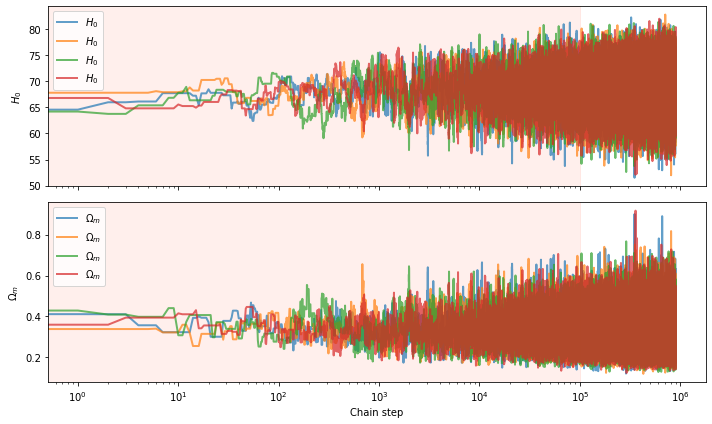

In [41]:
plt.figure(figsize=(10,5))
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
for chain, acceptance in results:
    axes[0].plot(chain[:, 0], lw=2, alpha=0.7, label=r'$H_0$')
    axes[1].plot(chain[:, 1], lw=2, alpha=0.7, label=r'$\Omega_m$')

axes[0].set_ylabel(r'$H_0$')
axes[0].legend()
axes[0].axvspan(0, 10**5, color='tomato', alpha=0.1, label='Burn-in')
axes[0].set_xscale('log')

axes[1].set_xlabel(r'Chain step')
axes[1].set_ylabel(r'$\Omega_m$')
axes[1].legend()
axes[1].axvspan(0, 10**5, color='tomato', alpha=0.1)
axes[1].set_xscale('log')


plt.tight_layout()
plt.show()

Exercici 4:

Veiem que les diferents execucions del Metropolis donen resultats molt similars segons el percentatges d'acceptació de samples i segons la mètrica R, la qual es troba entre 1 i 1.03 per cada un dels paràmetres.

In [23]:
for chain, accepted_count in results:
    print(accepted_count)

0.356928
0.35665
0.356519
0.355808


In [58]:
def gelman_rubin(chains):
        M = len(chains)
        N = len(chains[0])

        chain_means = np.mean(chains, axis=1)
        overall_mean = np.mean(chain_means)

        B = (1 / (M - 1)) * np.sum((chain_means - overall_mean) ** 2)
        W = np.mean([np.var(chain, ddof=1) for chain in chains])

        R = (((N - 1)*W / N)  +  B*(1+(1/M)))/ W
        return R

chain_list_h0 = [chain[:,0] for chain, accepted_count in results]
chain_list_om0 = [chain[:,1] for chain, accepted_count in results]
R_h0 = gelman_rubin(chain_list_h0)
R_om0 = gelman_rubin(chain_list_om0)
print(f'Gelman-Rubin score for H_0 chains = {R_h0}')
print(f'Gelman-Rubin score for Om_0 chains = {R_om0}')


Gelman-Rubin score for H_0 chains = 1.0000556896590962
Gelman-Rubin score for Om_0 chains = 1.0000772346020508


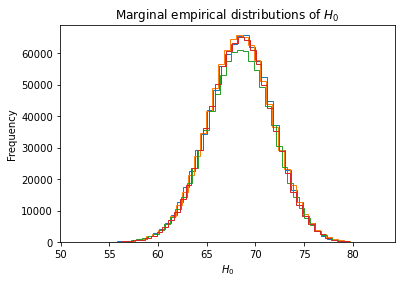

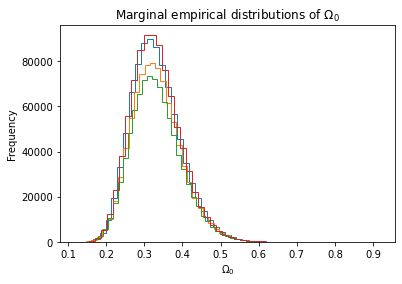

In [60]:
chain = [chain for chain in results]

for chain in chain_list:
    plt.hist(chain[:,0],bins=50,histtype="step")
plt.ylabel("Frequency")
plt.xlabel("$H_0$")
plt.title("Marginal empirical distributions of $H_0$")
plt.show()

for chain in chain_list:
    plt.hist(chain[:,1],bins=50,histtype="step")
plt.ylabel("Frequency")
plt.xlabel("$\Omega_0$")
plt.title("Marginal empirical distributions of $\Omega_0$")
plt.show()



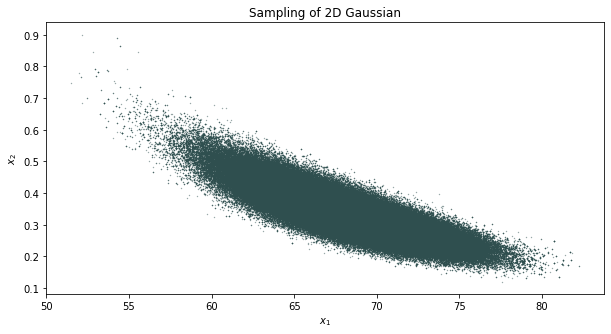

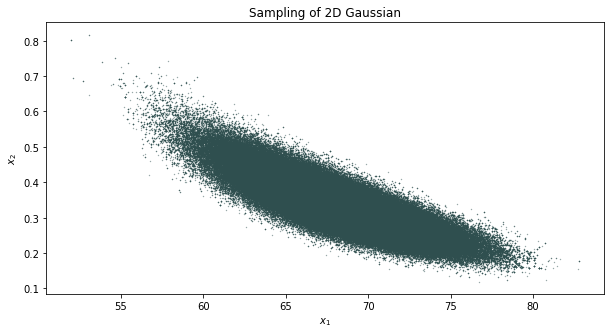

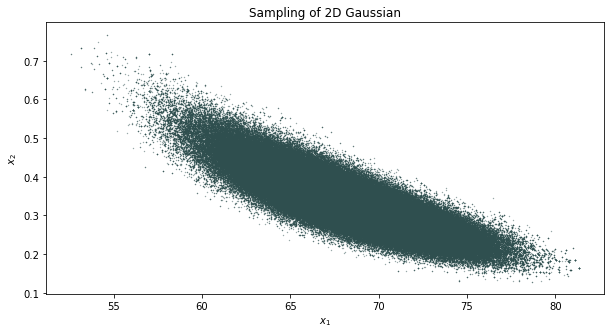

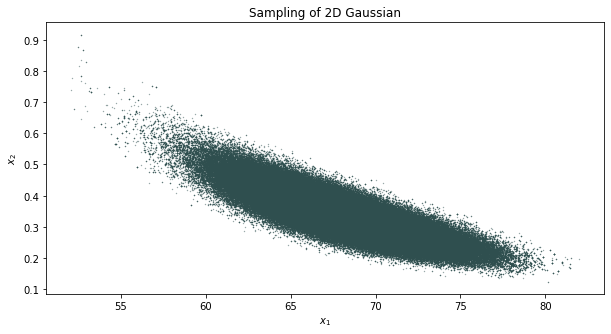

In [61]:
for chain in chain_list:
    plt.figure(figsize=(10,5))
    plt.scatter(chain[:,0], chain[:,1],0.1,color='darkslategrey',alpha=0.7)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'Sampling of 2D Gaussian')

In [62]:
def credible_interval(samples, ci=0.68):
    lower = np.percentile(samples, (1 - ci) / 2 * 100)
    upper = np.percentile(samples, (1 + ci) / 2 * 100)
    return lower, upper



ci_h0 = credible_interval(chain_list[0][:,0], ci=0.95)
ci_omega_m = credible_interval(chain_list[0][:,1], ci=0.95)

print(f"Interval de credibilitat de H_0 del 68%: {ci_h0}")
print(f"Interval de credibilitat de Omega_m del 68%: {ci_omega_m}")

Interval de credibilitat de H_0 del 68%: (61.71577240342793, 74.82000894694688)
Interval de credibilitat de Omega_m del 68%: (0.2203408834706487, 0.47569323491284377)


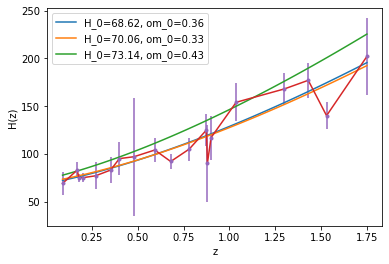

In [63]:
z_interval = np.linspace(np.min(z), np.max(z), 100)

h0_random = np.random.choice(chain_list[0][:,0], size=3)
om0_random = np.random.choice(chain_list[0][:,1], size=3)

for h0, om0 in zip(h0_random, om0_random):
    plt.plot(z_interval,H_model(z_interval,h0,om0))

plt.plot(z,h)
plt.xlabel("z")
plt.ylabel("H(z)")
plt.errorbar(z,h,yerr=herr,fmt=".")
plt.legend([f'H_0={round(h0,2)}, om_0={round(om0,2)}' for h0, om0 in zip(h0_random, om0_random)])